In [150]:
using Pkg
Pkg.activate("..")

using Distributions, LinearAlgebra, MiCRM, EasyFit, Distances, StatsBase
using OrdinaryDiffEq, DiffEqCallbacks
using CairoMakie, Colors, ColorSchemes
using JLD2
using Optim, ForwardDiff

  Activating project at `~/Projects/Working/ErCite/chemicalstressors`


In [2]:
Pkg.status()

Status `~/Projects/Working/ErCite/chemicalstressors/Project.toml`
⌃ [13f3f980] CairoMakie v0.9.2
  [35d6a980] ColorSchemes v3.19.0
  [5ae59095] Colors v0.12.8
  [459566f4] DiffEqCallbacks v2.24.3
  [b4f34e82] Distances v0.10.7
⌃ [31c24e10] Distributions v0.25.77
  [fde71243] EasyFit v0.5.7
  [f6369f11] ForwardDiff v0.10.33
  [033835bb] JLD2 v0.4.28
  [20f20a25] MakieCore v0.5.2
  [a39c0ef7] MiCRM v0.0.2 `~/Julia/Packages/MiCRM`
⌃ [429524aa] Optim v1.7.3
  [1dea7af3] OrdinaryDiffEq v6.31.2
  [2913bbd2] StatsBase v0.33.21
Info Packages marked with ⌃ have new versions available


# Introduction

In this notebook I do some exploratory analysis of a model in which stressors are linked to consumer dynamics by uptake. This uptake has negative consequences for consumers and removes the resources from the environment. 

The basic model is as follows:
\begin{align}
    \frac{dC}{dt} &= C_i \left(\sum_{\alpha} R_{\alpha} u_{i \alpha} \gamma_{\alpha}(1 - \lambda) - m_i\right)\\
    \frac{dR}{dt} &= \rho_\alpha - R_{\alpha} \omega_\alpha - \sum_{i} C_i  R_{\alpha} u_{i \alpha} + \sum_{\beta} R_{\beta} \sum_{i} C_i u_{i \beta} l_{\beta \alpha}
\end{align}

Or in a diagram:

<center>
<img src="figs/StressorDiagram.png" width="400">
</center>

Consumers uptake and leak resources as normal. The stressor acts as a resource but has a negative effect on growth of consumer populations. 

## Code

  0.761727 seconds (476.82 k allocations: 49.368 MiB, 79.76% compilation time: 100% of which was recompilation)
  0.217814 seconds (47.29 k allocations: 2.753 MiB, 27.27% compilation time: 100% of which was recompilation)


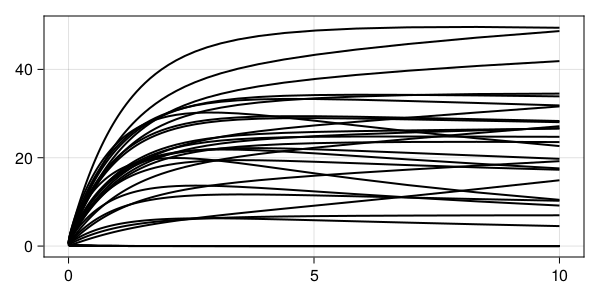

In [842]:
#solve system with stressor
#derivatives
function growth_MiCRM_detox!(dx,x,p,t,i)
    #mortality
    dx[i] += -p.m[i] * x[i]
    #resource uptake
    for α = 1:p.M
        tmp = 0.0
        for β = 1:p.M
            tmp += p.l[α,β]
        end
        dx[i] += x[α + p.N] * x[i] * p.u[i,α] * (1 - tmp) * p.kw.γ[i,α]
    end
end

#derivative function
dx!(dx,x,p,t) = MiCRM.Simulations.dx!(dx,x,p,t;  growth! = growth_MiCRM_detox!)


#params
function fu(N,M,kw)
    u = zeros(N,M)
    u[:, 1 : (M-1)] .= MiCRM.Parameters.modular_uptake(N,M - 1, N_modules = 5, s_ratio = kw[:u_ratio]) * kw[:u_tot]
    u[:, end] .= ones(N)
    return(u)
end

function fl(N,M,kw)
    l = MiCRM.Parameters.modular_leakage(M; N_modules = 5, s_ratio = kw[:l_ratio], λ = kw[:λ])
    #dont leak to or from stressor
    l[:,end] .= 0.0
    l[end,:] .= 0.0
    [l[i,:] .=  kw[:λ] * l[i,:] ./ sum(l[i,:]) for i = 1:(M-1)]
    return(l)
end

fρ(N,M,kw) = ones(M) * M 


N,M = 25,25

#gamma
γ = ones(N,M)
γ[:,end] .= 1.0

#generate test parameters
p = MiCRM.Parameters.generate_params(N, M, f_u = fu, f_l = fl, f_ρ = fρ, λ = 0.1, γ = γ, u_ratio = 100.0, l_ratio = 10.0, u_tot = 100.0)
p.ρ .= M
p.ρ[end] = 10.0

#simualtion params
x0 = rand(N+M)
t = (0.0,1e1)

prob = ODEProblem(dx!, x0, t, p)

@time sol1 = solve(prob, AutoTsit5(Rosenbrock23()));
@time sol2 = solve(prob, AutoTsit5(Rosenbrock23()), callback = TerminateSteadyState());

plot_sol(sol,ax) = Makie.series!(ax, sol.t, sol[:,:], solid_color = "black")


f = Figure(resolution = (600,300))
ax = Axis(f[1,1])
plot_sol(sol1,ax)
f

# Simulation details

### Resource Specialisation $s$
the degree to which consumers tend to specialise on their own resources

<center>
<img src="figs/Uptake_spec.png" width="400">
</center>

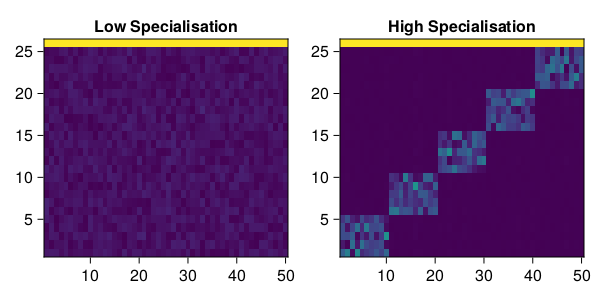

In [4]:
f = Figure(resolution = (600,300))

ax1 = Axis(f[1,1],title = "Low Specialisation")
ax2 = Axis(f[1,2],title = "High Specialisation")

heatmap!(ax1, fu(50,26,Dict(:u_ratio => 1.0)), colorrange = (0.0,1.0))
heatmap!(ax2, fu(50,26,Dict(:u_ratio => 100.0)), colorrange = (0.0,1.0))

f

### Leakage $\lambda$
The amount of resources leaked as metabolic by-products

<center>
<img src="figs/Leakage.png" width="400">
</center>

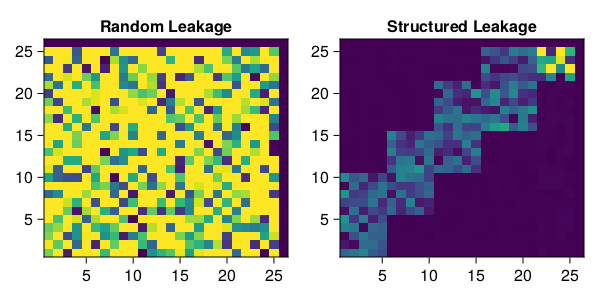

In [237]:
f = Figure(resolution = (600,300))

ax1 = Axis(f[1,1],title = "Random Leakage")
ax2 = Axis(f[1,2],title = "Structured Leakage")

heatmap!(ax1, fl(50,26,Dict(:l_ratio => 1.0, :λ => 0.5)), colorrange = (0.0,0.5 / 26))
heatmap!(ax2, fl(50,26,Dict(:l_ratio => 100.0, :λ => 0.5)), colorrange = (0.0,5 / 26))

f

In [238]:
r = JLD2.load("../data/detox_simulations.jld2")
analysis = JLD2.load("../data/analysis.jld2")

N_r,N_u, N_l, N_λ, N_ρ = size(r["J"])

s_vec = 10 .^ range(0, 2, length = N_u)
ρ_vec = ρ_vec = [0.0, 0.01, 0.1, 1.0]
λ_vec = [0.1, 0.3, 0.7]

mean_no_diag(A) = (sum(A) - sum(A[diagind(A)])) / (prod(size(A) .- [0, 1]))

mean_no_diag (generic function with 1 method)

# Return Time

The longterm response is determined by the structure of the community and is independet of the perturbation. Thus it is unlikely that the 

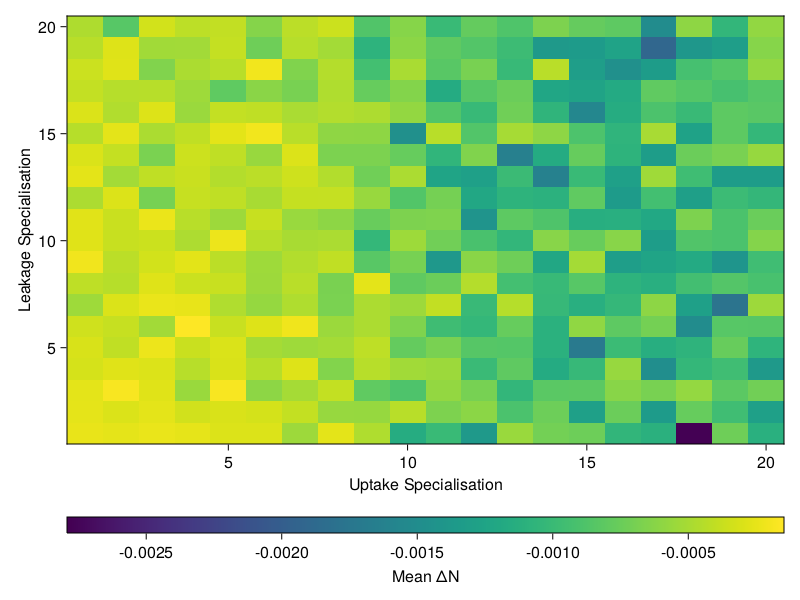

In [289]:
R = mean(Real.(analysis["Rinf"])[:,:,:,2,1],dims=(1))[1,:,:]
f= Figure()

ax = Axis(f[1,1], xlabel = "Uptake Specialisation", ylabel = "Leakage Specialisation")
heatmap!(ax,R, colormap = :viridis)

Colorbar(f[2,1], colormap = :viridis, vertical = false, flipaxis = false, label = "Mean ΔN", limits = extrema(R))

f

In [267]:
# f = Figure(resolution = (900,500))
# ax = [Axis(f[j,i]) for i = 1:3, j = 1:2]
# res = zeros(20,3)

# ρ = 1

# # #rescale rates
# for l = 1:3
#     for u = 1:20
#         R = Real.(analysis["Rinf"][:,u,:,l,ρ][:])
#         indxR = findall(R .< 0)
#         boxplot!(ax[l,1], fill(log(s_vec[u]), length(R[indxR])), log.(-R[indxR]), 
#             label = string(λ_vec[l]), color = "grey", width = 0.2, show_outliers = false)
#     end
    
#     for u = 1:20
#         R = Real.(analysis["Rinf"][:,:,u,l,ρ][:])
#         indxR = findall(R .< 0)
#         boxplot!(ax[l,2], fill(log(s_vec[u]), length(R[indxR])), log.(-R[indxR]), 
#             label = string(λ_vec[l]), color = "grey", width = 0.2, show_outliers = false)
#     end
# end

# axislegend.(ax, unique = true, position = :lb)
# linkaxes!(ax...)


# f

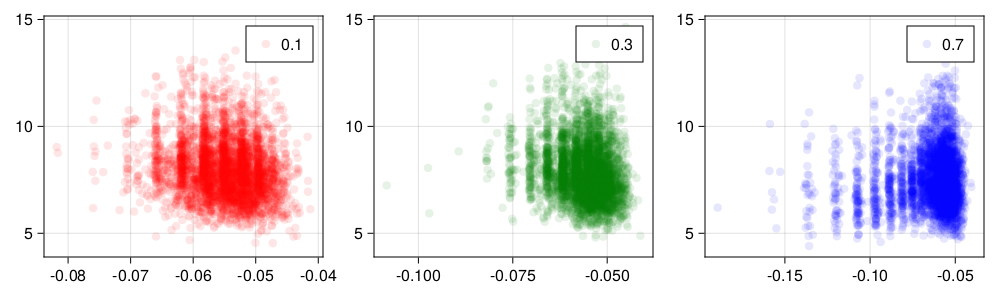

In [290]:
a_mean = mean_no_diag.(analysis["a_mat"])
λ = map(x -> Real(x), analysis["Rinf"])

f = Figure(resolution = (1000,300))
ax = [Axis(f[1,i]) for i = 1:3]
res = zeros(20,3)

ρ = 3

c = ["red","green","blue"]

# #rescale rates
for l = 1:3
        R = λ[:,:,:,l,ρ][:]
        a = a_mean[:,:,:,l,ρ][:]
        indxR = findall(R .< 0)
        scatter!(ax[l], (a[indxR]), log.(-1 ./ R[indxR]), label = string(λ_vec[l]), color = (c[l],0.1))
end

axislegend.(ax)
linkyaxes!(ax...)

f

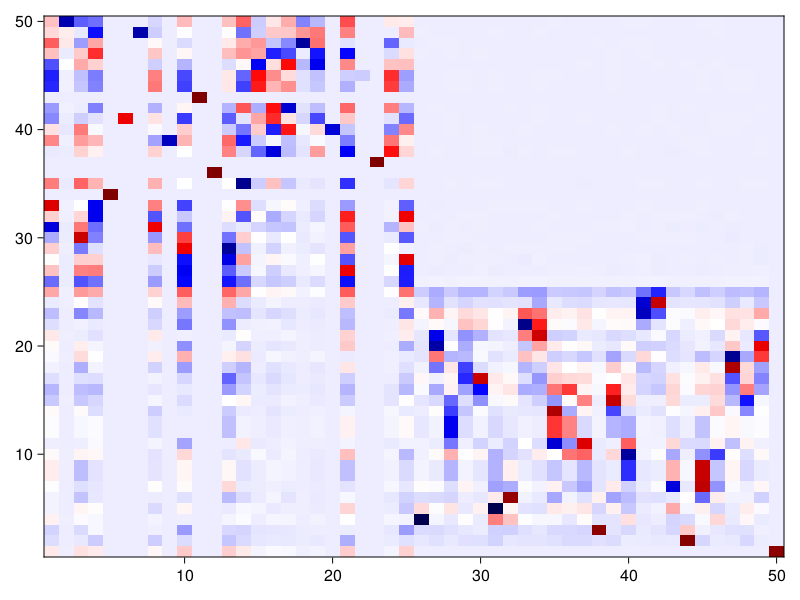

In [314]:
r["J"][1]

i = vcat( findall(r["mass"][1][1:25] .> eps()), 26:50)


λvecs = map(x -> x.re, eigvecs(r["J"][1]))
heatmap(λvecs, colormap = :seismic)


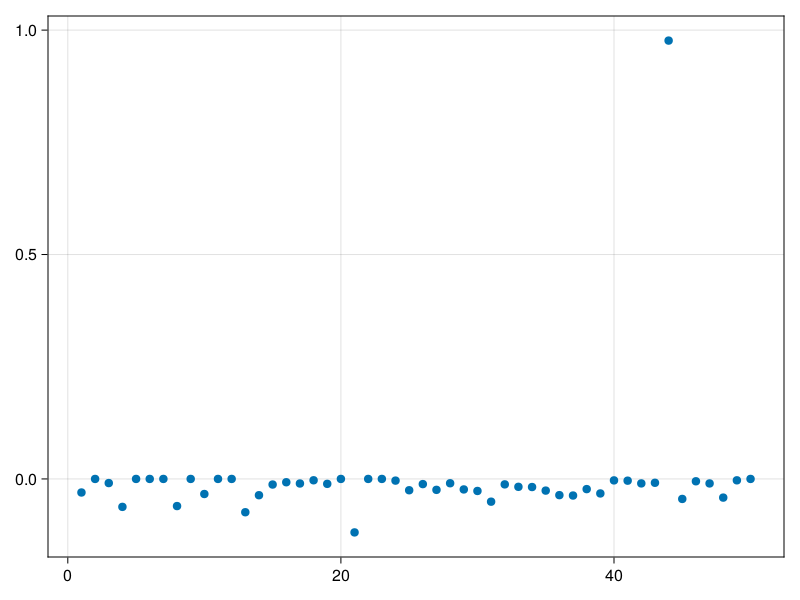

In [328]:
scatter(λvecs[:,2])

In [306]:
analysis["Rinf"][1]

-0.00016470275939907053 + 0.0im

# Maximum perturbation

The maximum pertubations size measures the largest displacement from equilibrium. This shows a strong relationship with the interaction measure, as interactions become more competitive the size of the maximal displacement increases. This suggests that competitive communities (i.e. those with many functionally similar species who negatively effect each other) are more susceptable to chemical perturbations. 

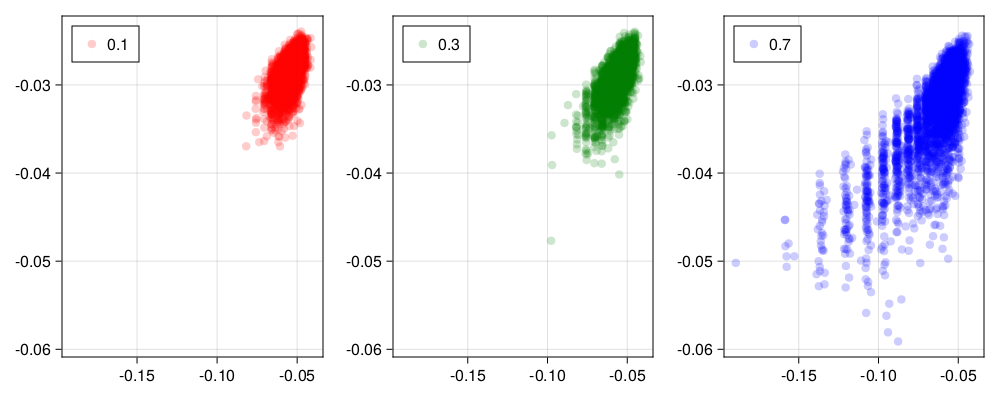

In [266]:
max_p = map(x -> x[1], analysis["max_p"])

f = Figure(resolution = (1000,400))
ax = [Axis(f[1,i]) for i = 1:3]
res = zeros(20,3)

c = ["red","green","blue"]


ρ = 1

# #rescale rates
for l = 1:3
        R = max_p[:,:,:,l,ρ][:]
        a = a_mean[:,:,:,l,ρ][:]
        indxR = findall(R .== R)
        scatter!(ax[l], (a[indxR]), R[indxR], label = string(λ_vec[l]), color = (c[l],0.2))
end

axislegend.(ax, position = :lt)
linkaxes!(ax...)

f

# Press Disturbance

In [243]:
function get_uptake_flux(mass,p)
    C = mass[1:25]
    R = mass[26:end]

    up_R = zeros(25)
    # a = 25
    for a = 1:25
        for i = 1:25
            up_R[a] -= p.u[i,a] * C[i] * R[a]
            for b = 1:25
                up_R[b] += p.u[i,b] * C[i] * R[b] * p.l[b,a]
            end

        end
    end
    return(sum(up_R))
end

get_uptake_flux (generic function with 1 method)

In [258]:
get_C(mass) = sum(mass[1 : 25])
get_R(mass) = sum(mass[26 : end-1])

C_mass = get_C.(r["mass"])
R_mass = get_R.(r["mass"]);
up_flux = get_uptake_flux.(r["mass"],r["p"])

#relative mass
ΔC = zeros(N_r,N_u,N_l,N_λ)
ΔR = zeros(N_r,N_u,N_l,N_λ)
ΔU = zeros(N_r,N_u,N_l,N_λ)

for rep = 1:N_r
    ΔC[rep,:,:,:] = C_mass[rep,:,:,:,2] .- C_mass[rep,:,:,:,1]
    ΔR[rep,:,:,:] = R_mass[rep,:,:,:,2] .- R_mass[rep,:,:,:,1]
    ΔU[rep,:,:,:] = up_flux[rep,:,:,:,2] .- up_flux[rep,:,:,:,1]
end

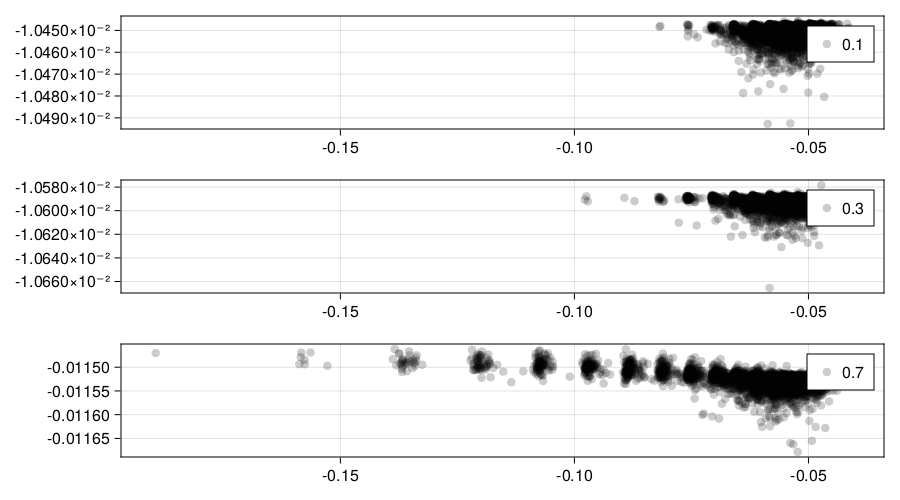

In [259]:
f = Figure(resolution = (900,500))
ax = [Axis(f[i,1]) for i = 1:3]
res = zeros(20,3)

ρ = 1

# #rescale rates
for l = 1:3
        C = ΔC[:,:,:,l][:]
        a = a_mean[:,:,:,l,ρ][:]
        scatter!(ax[l], (a), (C), label = string(λ_vec[l]), color = ("black",0.2))
end

axislegend.(ax)
linkxaxes!(ax...)

f

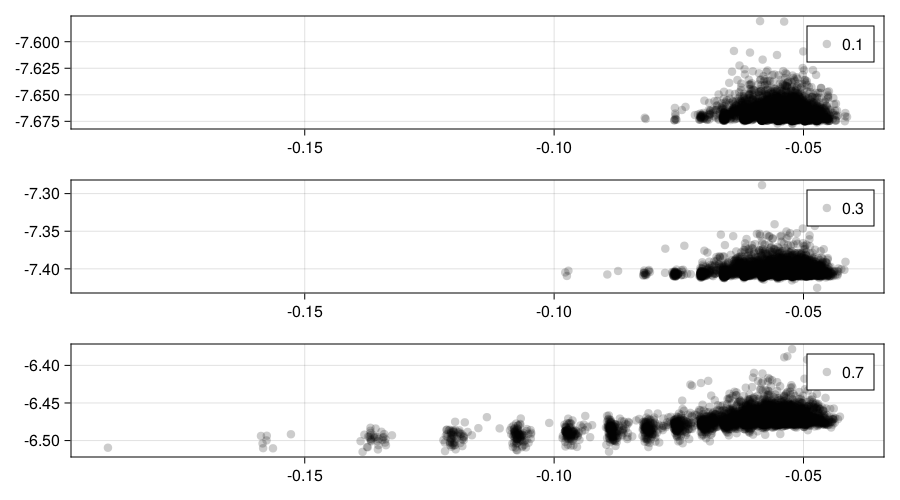

In [260]:

f = Figure(resolution = (900,500))
ax = [Axis(f[i,1]) for i = 1:3]
res = zeros(20,3)

ρ = 1

# #rescale rates
for l = 1:3
        R = ΔR[:,:,:,l][:]
        a = a_mean[:,:,:,l,ρ][:]
        scatter!(ax[l], (a), log.(R), label = string(λ_vec[l]), color = ("black",0.2))
end

axislegend.(ax)
linkxaxes!(ax...)

f

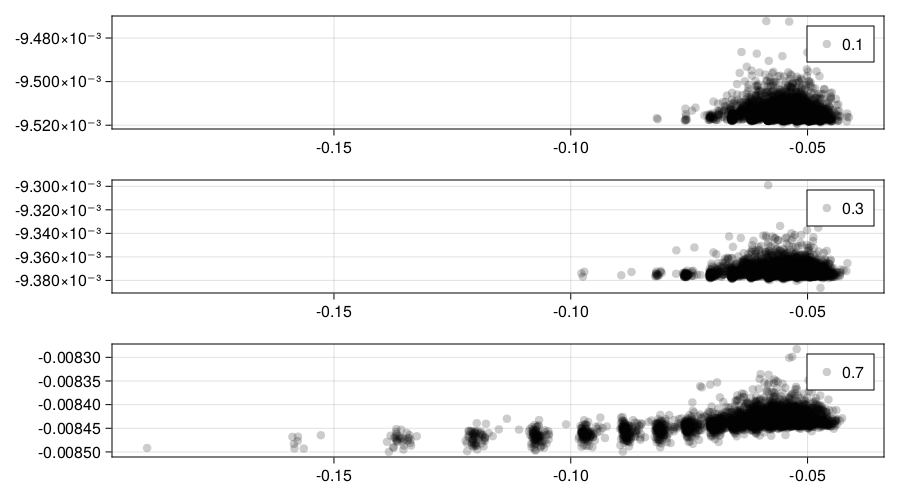

In [261]:
f = Figure(resolution = (900,500))
ax = [Axis(f[i,1]) for i = 1:3]
res = zeros(20,3)

ρ = 1

# #rescale rates
for l = 1:3
        U = ΔU[:,:,:,l][:]
        a = a_mean[:,:,:,l,ρ][:]
        scatter!(ax[l], a, U, label = string(λ_vec[l]), color = ("black",0.2))
end

axislegend.(ax)
linkxaxes!(ax...)

f

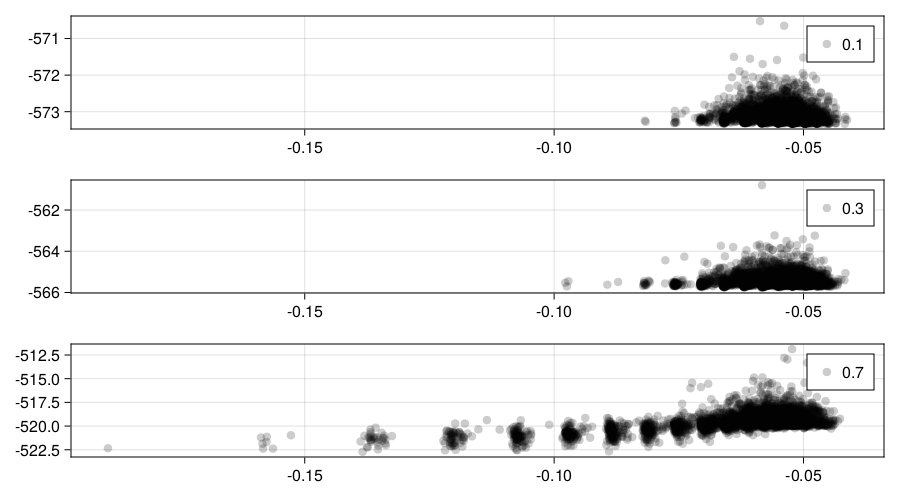

In [262]:

f = Figure(resolution = (900,500))
ax = [Axis(f[i,1]) for i = 1:3]
res = zeros(20,3)

ρ = 1

# #rescale rates
for l = 1:3
        R = up_flux[:,:,:,l,ρ][:]
        a = a_mean[:,:,:,l,ρ][:]
        scatter!(ax[l], (a), (R), label = string(λ_vec[l]), color = ("black",0.2))
end

axislegend.(ax)
linkxaxes!(ax...)

f

In [742]:
#testing quantities
f_Rtot(p,Rs) = mean(p.m + p.u[:,end] * Rs) / (mean(p.u[:,1:24]) * (1 - p.kw.λ))
f_Ctot(p,Rs) = (sum(p.ρ) - f_Rtot(p, Rs))/((1 - p.kw.λ)*mean(p.u[:,1:24]) * f_Rtot(p,Rs))
f_Rs(p,Ctot) = p.ρ[end] / (p.ω[end] + Ctot) 

f_Rs (generic function with 1 method)

In [743]:
p_ = r["p"][1,20,20,3,end]
m_ = r["mass"][1,20,20,3,end];

In [744]:
println("resources: ", sum(m_[26:end-1]),"  ",f_Rtot(p_,m_[end]))
println("Consumers: ", sum(m_[1:25]),"  ",f_Ctot(p_,m_[end]))
println("Stressor: ",  m_[end],"  ",Rs(p_,f_Ctot(p_,m_[end])))

resources: 82.53566061939888  80.15459944801874
Consumers: 516.4662718737012  519.8408117700154
Stressor: 0.0019324931002345043  0.0019199724318868547


In [761]:
p_ = r["p"][1,1,1,1,:]
m_ = r["mass"][1,1,1,1,:]


hcat(f_Rtot.(p_, [x[end] for x = m_]), map(x -> sum(x[26:49]), m_))

# map(x -> sum(x[1:25]), m_)

4×2 Matrix{Float64}:
 26.6667  26.8053
 26.6671  26.8057
 26.6713  26.8099
 26.7132  26.852

In [762]:
hcat(f_Ctot.(p_, [x[end] for x = m_]), map(x -> sum(x[1:25]), m_))

4×2 Matrix{Float64}:
 573.333  573.195
 573.333  573.184
 573.329  573.09
 573.287  572.15

In [763]:
hcat(Rs.(p_, f_Ctot.(p_, [x[end] for x = m_])), map(x -> sum(x[end]), m_))

4×2 Matrix{Float64}:
 0.0          1.087e-321
 1.74115e-5   1.7416e-5
 0.000174116  0.000174189
 0.00174129   0.00174474

In [757]:
u

25×24 Matrix{Float64}:
 0.230464     0.110155     0.236575     …  0.00164936   0.00115806
 0.163883     0.21166      0.183163        0.00313846   0.000545338
 0.252508     0.160696     0.258625        0.00145835   0.000564195
 0.188051     0.152364     0.334522        0.000326617  0.00213413
 0.202887     0.101971     0.229001        0.0010389    0.00259522
 0.0011197    0.000306436  0.000435491  …  0.0018445    0.00169885
 0.00210516   4.30934e-5   0.00239534      0.00196198   0.00240156
 0.00170921   0.00141154   0.000890834     0.00171319   0.00207595
 0.00178666   0.00016299   0.0015877       0.00251759   0.00487629
 0.0010341    0.00223285   0.0010222       0.000196382  0.0027897
 7.04799e-5   0.00370983   0.000611653  …  0.00120271   0.000228547
 0.00360431   0.00288265   0.00332196      0.00063883   0.00406689
 0.00151893   0.00309986   0.00389951      0.00116317   0.00227981
 0.00285219   0.00267219   0.0023332       2.95981e-5   0.000578419
 0.00340303   0.00451102   0.0005544

In [707]:
sR_s1 = substitute(sR_s, Dict(C_tot => sC_tot))
sR_tot1 = substitute(sR_tot, Dict(R_s => sR_s1))

LHS = R_tot * u *(1-λ) * (ω_s + (ρ - R_tot)/(R_tot*u*(1-λ))) * (R_tot*u*(1-λ))
RHS = sR_tot1 *u *(1-λ) * (ω_s + (ρ - R_tot)/(R_tot*u*(1-λ))) * (R_tot*u*(1-λ))


collect
(simplify(LHS - RHS, expand = true))

R_tot*m + R_tot*u*ρ + u*λ*(R_tot^2) + ω_s*(R_tot^2)*(u^2) + ω_s*(R_tot^2)*(u^2)*(λ^2) + R_tot*m*u*λ*ω_s + R_tot*u*u_s*λ*ρ_s - m*ρ - u*(R_tot^2) - R_tot*u*λ*ρ - R_tot*m*u*ω_s - R_tot*u*u_s*ρ_s - 2.0λ*ω_s*(R_tot^2)*(u^2)

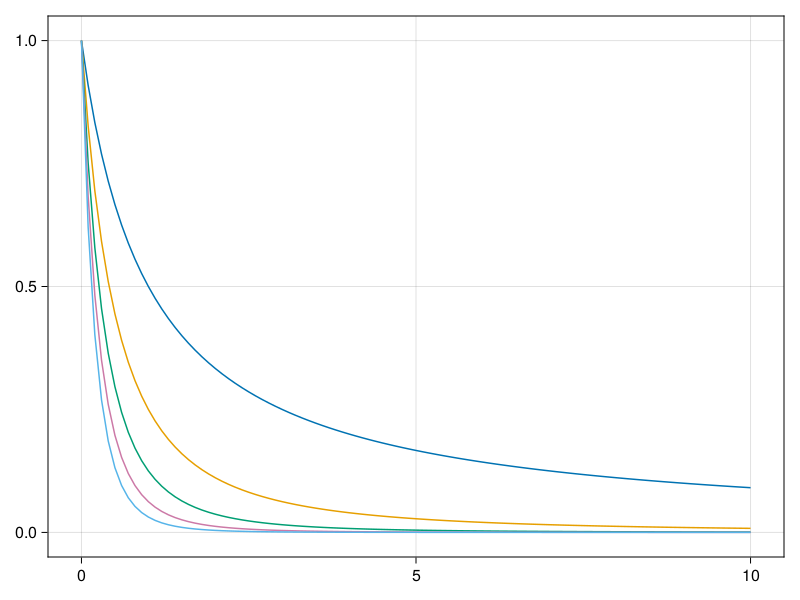

In [722]:
x_vec = 0.0:0.1:10.0

f_(x,a) = 1 / (x + 1) .^ a

f = lines(x_vec , f_.(x_vec,1))
[lines!(f.axis, x_vec , f_.(x_vec,i) ) for i = 2:5]

f

In [788]:
p_ = r["p"][1,20,20,3,end]
m_ = r["mass"][1,20,20,3,end];

u = p_.u[:,1:24]
C = m_[1:25]
R = m_[26:49];


In [790]:
[sum(C .* u[:,a]) for a = 1:24] |> sum

516.4662718737013

In [792]:
(25*mean(u,dims=1)*mean(C))[:] .+ 25 * [cov(u[:,a],C) for a = 1:24] |> sum

516.4662718737013

In [794]:
function f_cov(p,m)
    
    u = p.u[:,1:24]
    C = m[1:25]
    R = m[26:49];
    
    
    sum(25 * [cov(u[:,a],C) for a = 1:24])
end

f_cov (generic function with 1 method)

In [819]:
cov(mean(u, dims = 1)[:],R)

-0.006745663192387195

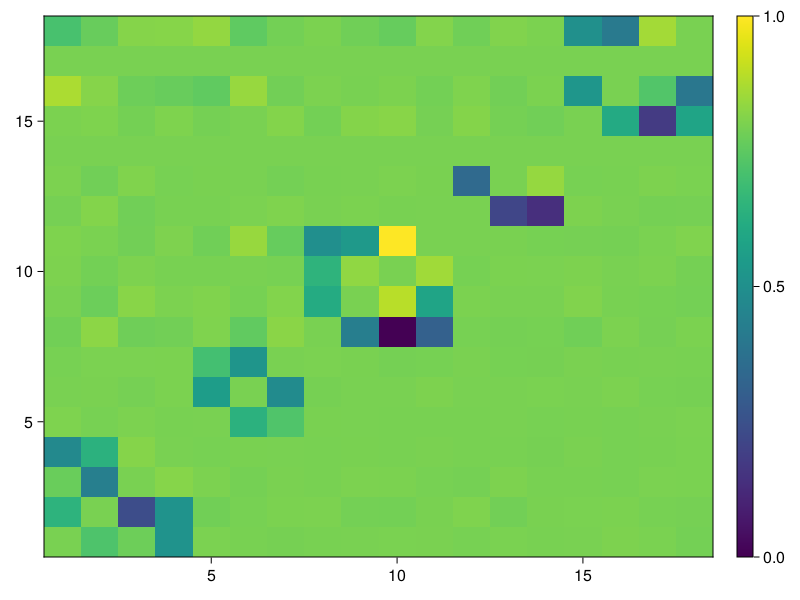

In [837]:
a = analysis["a_mat"][10,20,20,3,1]

a[diagind(a)] .= 0.0

f = heatmap(a)
Colorbar(f.figure[1,2], )

f

In [777]:
sum([u[i,a] * R[a] * C[i] for i = 1:25, a = 1:24])

634.3132803520461

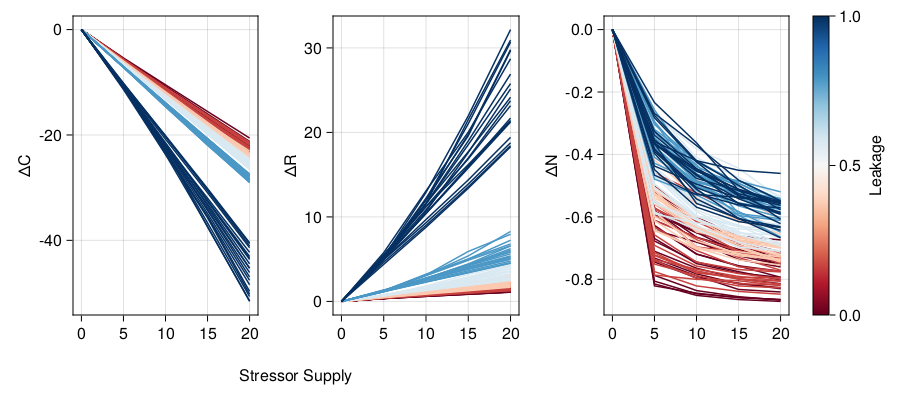

In [215]:
ΔC_mean = mean(sum.(ΔC), dims = 1)[1,:,:,:]
ΔR_mean = mean(sum.(ΔR), dims = 1)[1,:,:,:]
ΔN_mean = mean(sum.(ΔN), dims = 1)[1,:,:,:]

colors = resample_cmap(:RdBu, N_λ)

f = Figure(resolution = (900,400))

ax = [Axis(f[1,i], ylabel = ["ΔC","ΔR","ΔN"][i]) for i = 1:3]

for λ = Int.(floor.(range(1,N_λ, length = 6)))
    [lines!(ax[1], ρ_vec, ΔC_mean[λ,i,:], color = colors[λ]) for i = 1:N_s]
    [lines!(ax[2], ρ_vec, ΔR_mean[λ,i,:], color = colors[λ]) for i = 1:N_s]
    [lines!(ax[3], ρ_vec, ΔN_mean[λ,i,:], color = colors[λ]) for i = 1:N_s]

end

Colorbar(f[1,4], limits = (0, 1), colormap = :RdBu, label = "Leakage")
Label(f[2,1:2],"Stressor Supply")

f

Here we see that the change in consumers $\Delta C$ generally decreases with stressor supply. This effect is weaker at higher leakage levels and is even positive as leakage tends to mid-high values. Within each leakage group is the specialisation which has little effect on the average response. 

Resources $\Delta R$ increase with stressor supply and this effect is more pronounced as leakage increases. 

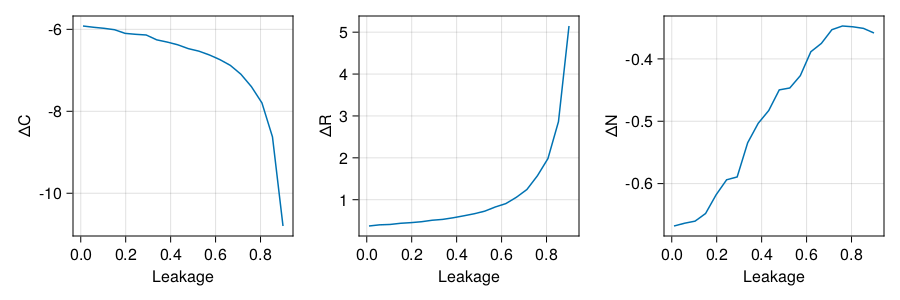

In [216]:
f = Figure(resolution = (900,300))
ax = [Axis(f[1,i], xlabel = "Leakage", ylabel = ["ΔC","ΔR","ΔN"][i]) for i = 1:3]

lines!(ax[1], λ_vec, mean(ΔC_mean,dims=2)[:,1,2])
lines!(ax[2], λ_vec, mean(ΔR_mean,dims=2)[:,1,2])
lines!(ax[3], λ_vec, mean(ΔN_mean,dims=2)[:,1,2])

f



These results are demonstrated here, consumer mass decreases with the stressor whilst resources tend to increase. 

## Variation in Population Responses

Above we characterise community level responses but here we consider how individual populations respond to the stressor. We can do this by calculating the slope of their biomass with respect to the stressor abundance. 

In [285]:
# #plot individual species
# f = Figure(resolution = (700,700))

# for (i,v1) = enumerate(1:5:N_λ), (j,v2) = enumerate(1:5:N_s)
#     ax = Axis(f[i,j],title = string("λ",v1," s",v2))
#     [series!(ax, ρ_vec[1:2], hcat(ΔC[r,v1,v2,1:3]...), solid_color = ("black", 0.1)) for r = 1]
# end

# Makie.hidedecorations!.(f.content,grid = false)
# # Makie.linkaxes!(f.content...)
# # Makie.ylims!.(f.content,-100,100)

# f

get_sym_lims (generic function with 1 method)

In [221]:
C_slopes = Array{Vector{Float64}, 3}(undef, N_r, N_λ, N_s)
R_slopes = Array{Vector{Float64}, 3}(undef, N_r, N_λ, N_s)
N_slopes = Array{Vector{Float64}, 3}(undef, N_r, N_λ, N_s)

Threads.@threads for r = 1:N_r
    for λ = 1:N_λ
        for s = 1:N_s
            rows = eachrow(hcat(ΔC[r,λ,s,:]...)[extant_C[r,λ,s,1],:])
            C_slopes[r,λ,s] = [i[2] for i  in rows] #[fitlinear(ρ_vec, r).a for r = rows]
            
            rows = eachrow(hcat(ΔR[r,λ,s,:]...))
            R_slopes[r,λ,s] = [i[2] for i  in rows] #[fitlinear(ρ_vec, r).a for r = rows]
            
            rows = eachrow(hcat(ΔN[r,λ,s,:]...))
            N_slopes[r,λ,s] = [i[2] for i  in rows] #[fitlinear(ρ_vec, r).a for r = rows]
        end
    end
end

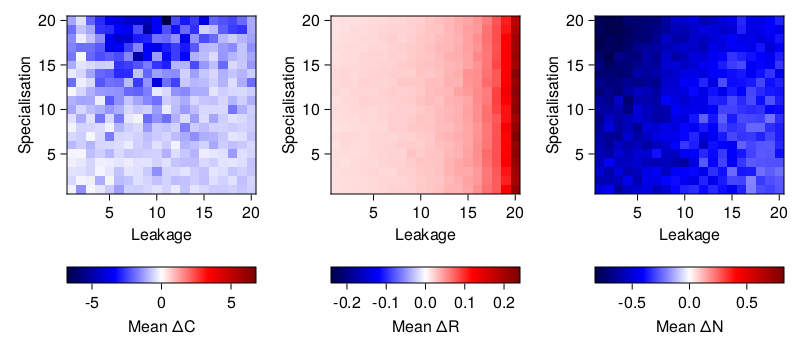

In [222]:
f = Figure(resolution = (800,350))

#vs leakage
ax = [Axis(f[1,i], xlabel = "Leakage", ylabel = "Specialisation") for i = 1:3]

x = mean(mean.(C_slopes),dims=1)[1,:,:]
heatmap!(ax[1], x, colormap = :seismic, colorrange = get_sym_lims(x))
Colorbar(f[2,1], colormap = :seismic, vertical = false, flipaxis = false, label = "Mean ΔC", limits = get_sym_lims(x))

x = mean(mean.(R_slopes),dims=1)[1,:,:]
heatmap!(ax[2], x, colormap = :seismic, colorrange = get_sym_lims(x))
Colorbar(f[2,2], colormap = :seismic, vertical = false, flipaxis = false, label = "Mean ΔR", limits = get_sym_lims(x))

x = mean(mean.(N_slopes),dims=1)[1,:,:]
heatmap!(ax[3], x, colormap = :seismic, colorrange = get_sym_lims(x))
Colorbar(f[2,3], colormap = :seismic, vertical = false, flipaxis = false, label = "Mean ΔN", limits = get_sym_lims(x))


f

On average we see the expected responses, the slope of responses increases with leakage for consumers up to a point (~0.8). Above this leakage appears to have string negative effects. I think this mihgt be a crirtical point where populations become unviable. 

Resource specialisation has a relatively minor effect, reducing the strength of this effect. Interactions mediate the effects of leakage. 

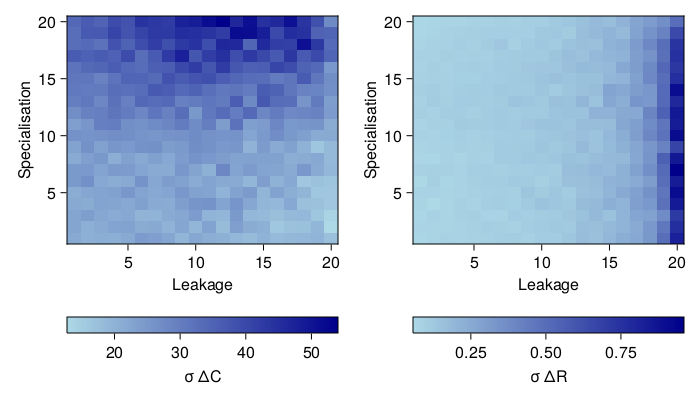

In [223]:
f = Figure(resolution = (700,400))

#vs leakage
ax = [Axis(f[1,i], xlabel = "Leakage", ylabel = "Specialisation") for i = 1:2]

x = sqrt.(mean(var.(C_slopes),dims=1)[1,:,:])
heatmap!(ax[1], x, colormap = :blues,colorrange = extrema(x))
Colorbar(f[2,1], colormap = :blues, vertical = false, flipaxis = false, label = "σ ΔC", limits = extrema(x))


x = sqrt.(mean(var.(R_slopes),dims=1)[1,:,:])
heatmap!(ax[2], x, colormap = :blues, colorrange = extrema(x))
Colorbar(f[2,2], colormap = :blues, vertical = false, flipaxis = false, label = "σ ΔR", limits = extrema(x))

f

The variation in responses is higher in less specialised (more competitive) communtities. The variation increases with leakage in specialised communties but remains the same in non-specialised. At higher leakages the variation declines in both. 

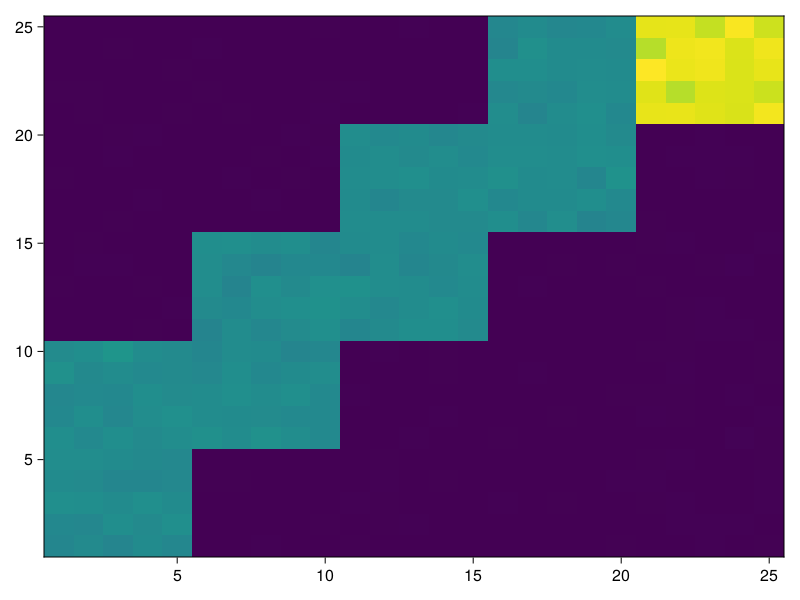

In [436]:
l = MiCRM.Parameters.modular_leakage(25,25,Dict{Symbol, Any}(:N_modules => 5, :s_ratio => 1000.0, :λ => 1.0))

heatmap(l)

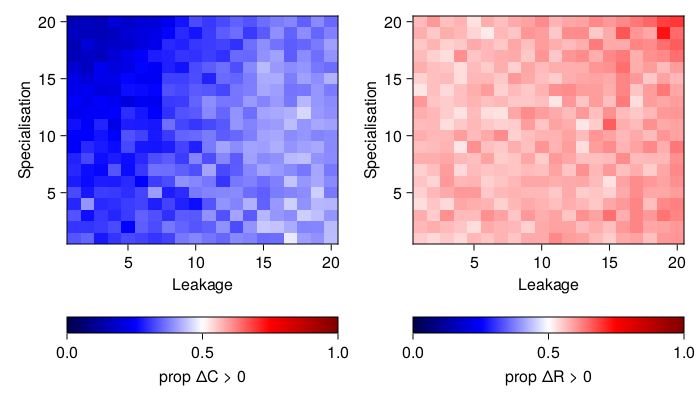

In [224]:
f = Figure(resolution = (700,400))

#vs leakage
ax = [Axis(f[1,i], xlabel = "Leakage", ylabel = "Specialisation") for i = 1:2]

x = mean(map( x -> sum(x .> 0.0) / length(x),  C_slopes), dims = 1)[1,:,:]
heatmap!(ax[1], x, colormap = :seismic, colorrange = (0,1))
Colorbar(f[2,1], colormap = :seismic, vertical = false, flipaxis = false, label = "prop ΔC > 0", limits = (0,1))


x = mean(map( x -> sum(x .> 0.0) / length(x),  R_slopes), dims = 1)[1,:,:]
heatmap!(ax[2], x, colormap = :seismic, colorrange = (0,1))
Colorbar(f[2,2], colormap = :seismic, vertical = false, flipaxis = false, label = "prop ΔR > 0", limits = (0,1))

f

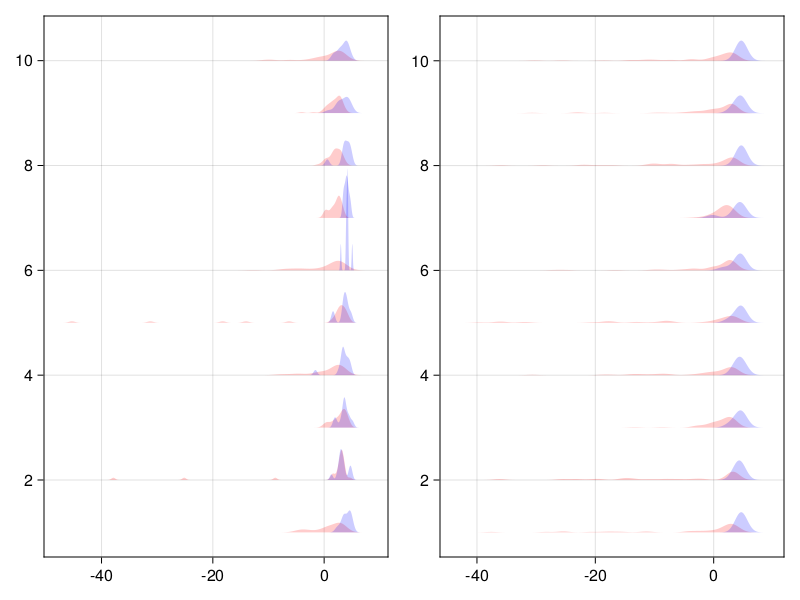

In [225]:
f = Figure()

ax1 = Axis(f[1,1])
ax2 = Axis(f[1,2])

C_plot = map(y -> log.(filter(x -> x > 0, y)), C) 

for r = 1:N_r
    Makie.density!(ax1, C_plot[r,1,1,1], label = "Baseline", color = ("red", 0.2), offset = r)
    Makie.density!(ax1, C_plot[r,1,1,end], label = "Baseline", color = ("blue", 0.2), offset = r)
end

for r = 1:N_r
    Makie.density!(ax2, C_plot[r,1,end,1], label = "Baseline", color = ("red", 0.2), offset = r, bandwidth = 1.0)
    Makie.density!(ax2, C_plot[r,1,end,end], label = "Baseline", color = ("blue", 0.2), offset = r,bandwidth = 1.0)
end

f

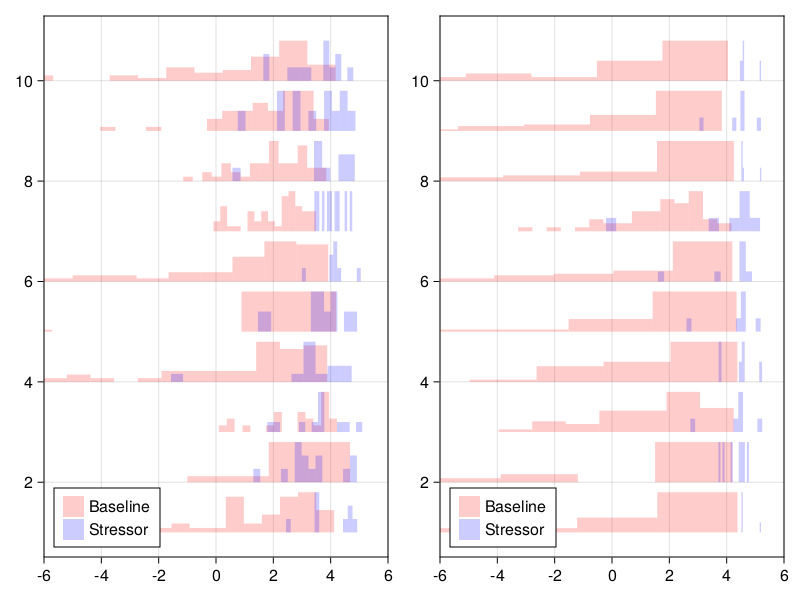

In [226]:
f = Figure()

ax1 = Axis(f[1,1])
ax2 = Axis(f[1,2])

C_plot = map(y -> log.(filter(x -> x > 0, y)), C) 

for r = 1:N_r
    Makie.hist!(ax1, C_plot[r,1,1,1], label = "Baseline", color = ("red", 0.2), offset = r, normalization = :pdf, scale_to = 0.8)
    Makie.hist!(ax1, C_plot[r,1,1,end], label = "Stressor", color = ("blue", 0.2), offset = r, normalization = :pdf, scale_to = 0.8)
end

for r = 1:N_r
    Makie.hist!(ax2, C_plot[r,1,end,1], label = "Baseline", color = ("red", 0.2), offset = r, normalization = :pdf, scale_to = 0.8)
    Makie.hist!(ax2, C_plot[r,1,end,end], label = "Stressor", color = ("blue", 0.2), offset = r, normalization = :pdf, scale_to = 0.8)
end

Makie.axislegend(ax1, unique = true, position = :lb)
Makie.axislegend(ax2, unique = true, position = :lb)

Makie.xlims!(ax1, -6,6)
Makie.xlims!(ax2, -6,6)


f

In [378]:
indx = findall(sum(r["J"][3],dims=2)[:] .!= 0)
J_obs = r["J"][3][indx,indx]

N = findall(J_obs[1,:] .!= 0.0)[2] - 1
M = size(J_obs)[2] - N

w = zeros(N+M)
w[1:N] .= 1
    
u = zeros(N+M)
u[end] = 1 

a_tmp = zeros(N,N)

for i = 1:N
    for j = 1:N
        a_tmp[i,j] = J_obs[i, N+1 : end]' * J_obs[N+1 : end, j]
    end
end



-0.6249603468097719

In [402]:
# MiCRM.Analysis.get_return_rate.(r["J"])
R_inf = similar(r["J"], Float64)
a_mean = similar(r["J"], Float64)
for (i,v) in enumerate(r["J"])
    indx = findall(sum(v,dims=2)[:] .!= 0)
    J_obs = v[indx,indx]

    N = findall(J_obs[1,:] .!= 0.0)[2]-1
    M = size(J_obs)[2] - N
    
    #interactions
    a_tmp = zeros(N,N)

    for i = 1:N
        for j = 1:N
            a_tmp[i,j] = J_obs[i, N+1 : end]' * J_obs[N+1 : end, j]
        end
    end
    
    a_mean[i] = mean(a_tmp)
    
    w = zeros(N+M)
    w[1:N] .= 1
    
    u = zeros(N+M)
    u[end] = 1 
    
    try
        R_inf[i] = MiCRM.Analysis.get_Rins(J_obs, u, 1.0, w)
    catch
        R_inf[i] = MiCRM.Analysis.get_Rins(J_obs, u, 1.0, w)
    end
end

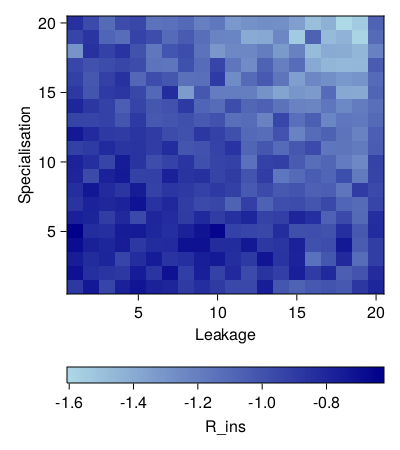

In [405]:
R_ins_avg = median(R_inf[:,:,:,1], dims = 1)[1,:,:]

f = Figure(resolution = (400,450))
ax = Axis(f[1,1], xlabel = "Leakage", ylabel = "Specialisation")

heatmap!(ax, R_ins_avg, colormap = :blues)
Colorbar(f[2,1], colormap = :blues, vertical = false, flipaxis = false, label = "R_ins", limits =extrema(R_ins_avg))

f

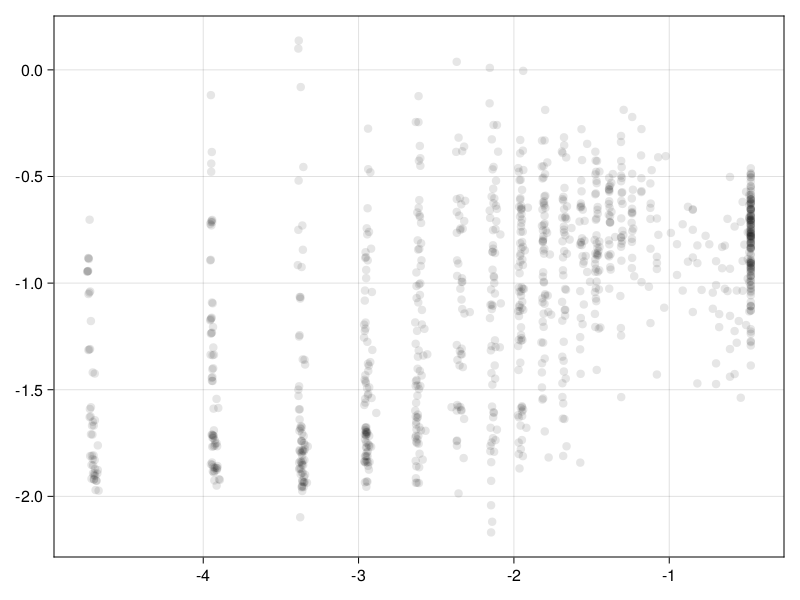

In [411]:
# scatter(a_mean[:], )
scatter(a_mean[:,1,:,:][:], R_inf[:,1,:,:][:], color = ("black",0.1))

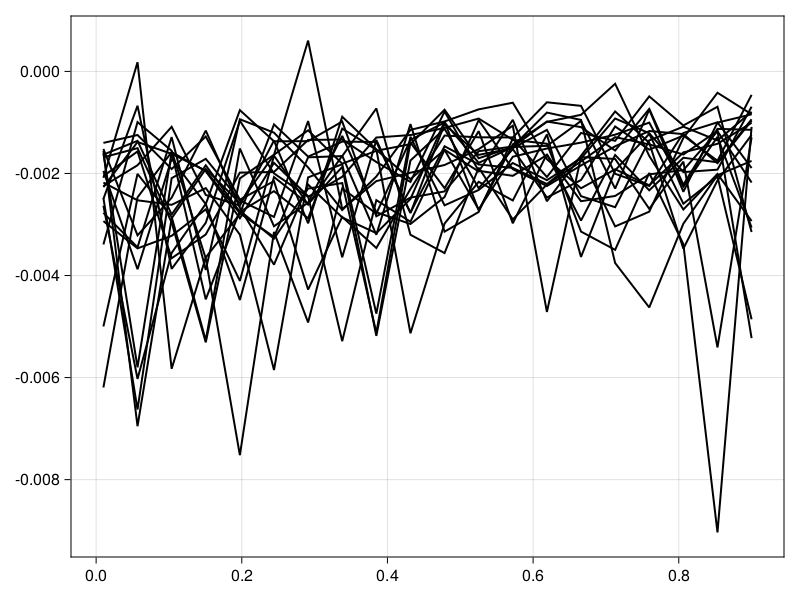

In [265]:
series((λ_vec), R_inf[1,:,:,1], solid_color = "black")
[r,l,i,j]

In [284]:
v = r["J"][1]
N = findfirst(v[1,2:end] .> 0)
M = size(v)[1] - N

24

In [295]:
r["J"][1][51,:]

74-element Vector{Float64}:
 -0.056602344232824536
 -0.03235788060402686
 -0.021967341444095793
 -0.06332765235505361
 -0.022795531075817773
 -0.061221528712024464
 -0.002776445673639467
 -0.057003398565823885
 -0.009363078450444552
 -0.028203002755911796
 -0.03277717272736579
 -0.02054567830420069
 -0.002958132815421552
  ⋮
  0.0037507041854417866
  0.0023590850185582443
  0.0030516789125679235
  0.017385027944240718
  0.014258611718893949
  0.016233696479340195
  0.008642627255071639
  0.019000850185889834
  0.0006136436685493326
  0.007725506943292113
  0.007570105966560026
  0.003115213390975712